# Natural Language Processing with TensorFlow

Natural language is a broad term but you can consider it to cover any of the following:

- Text (such as that contained in an email, blog post, book, Tweet)
- Speech (a conversation you have with a doctor, voice commands you give to a smart speaker)

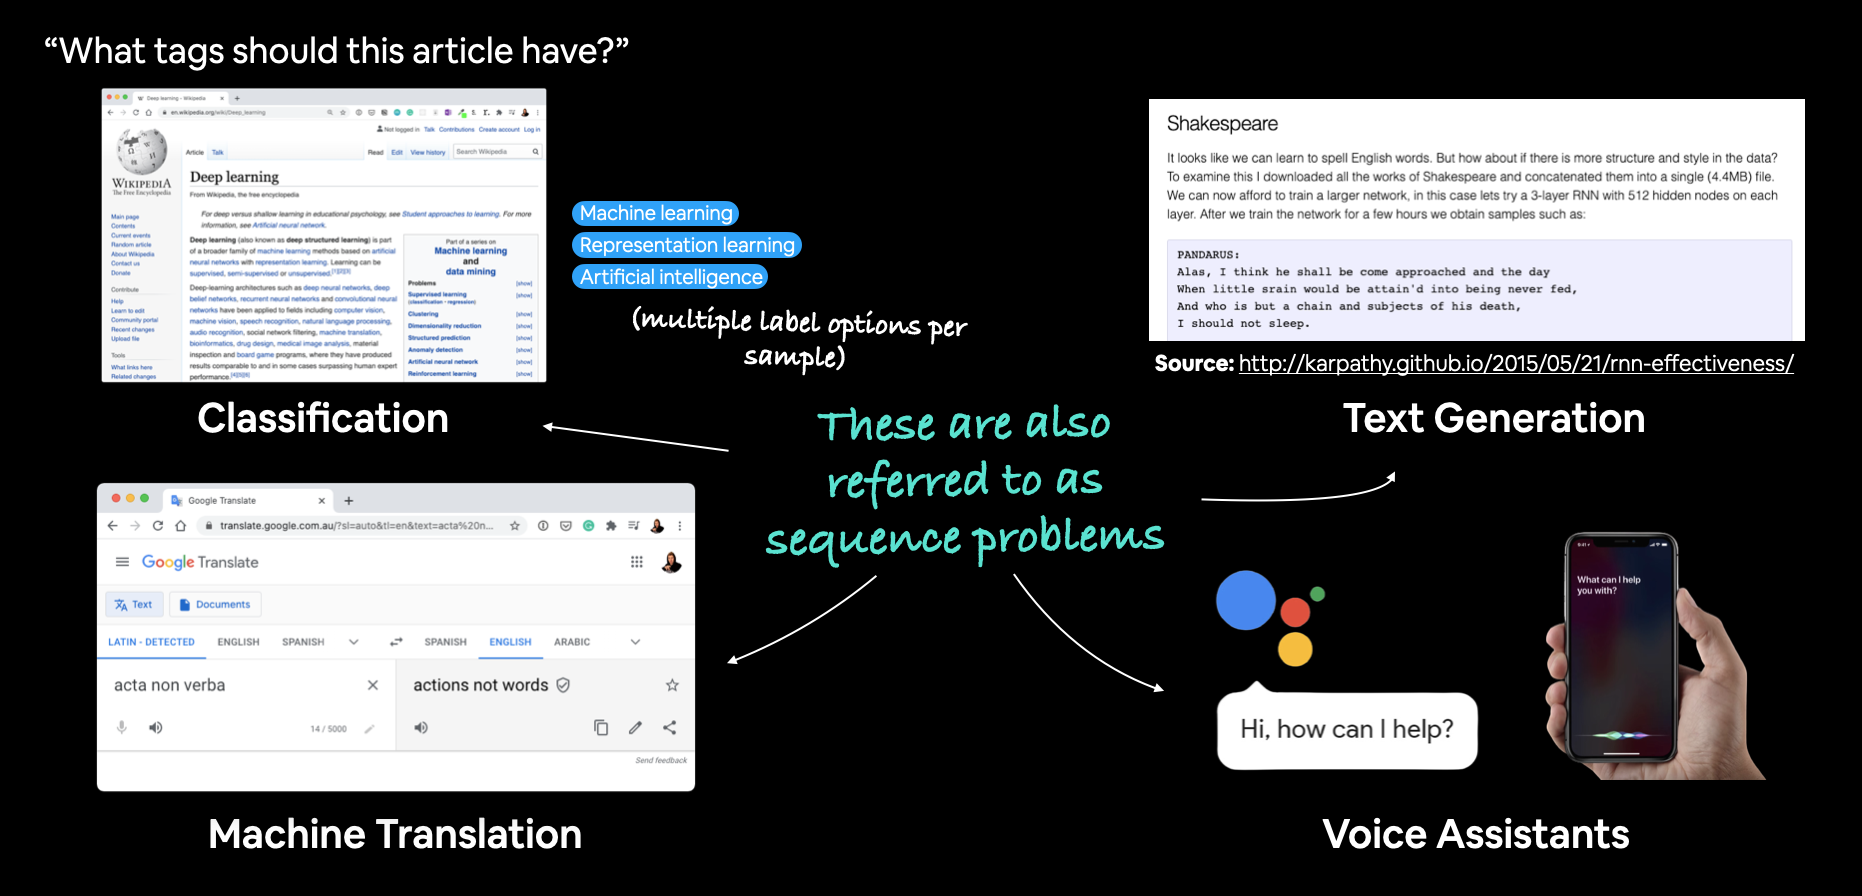

If you're building an email application, you might want to scan incoming emails to see if they're spam or not spam (classification).

If you're trying to analyse customer feedback complaints, you might want to discover which section of your business they're for.

🔑 Note: Both of these types of data are often referred to as sequences (a sentence is a sequence of words). So a common term you'll come across in NLP problems is called seq2seq, in other words, finding information in one sequence to produce another sequence (e.g. converting a speech command to a sequence of text-based steps).

Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)

In [3]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-09-15 15:04:22.750057


In [4]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download a text dataset

Let's start by download a text dataset. We'll be using the [Real or Not?](https://www.kaggle.com/competitions/nlp-getting-started/data) dataset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about disasters, for example:

Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
The Not Real Tweets are Tweets not about disasters (they can be on anything), for example:

'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote



In [5]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data('nlp_getting_started.zip')

--2023-09-15 15:04:29--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.199.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-09-15 15:04:29 (162 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping nlp_getting_started.zip gives the following 3 .csv files:

- sample_submission.csv - an example of the file you'd submit to the Kaggle competition of your model's predictions.
- train.csv - training samples of real and not real diaster Tweets.
- test.csv - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset

In [6]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The training data we downloaded is probably shuffled already. But just to be sure, let's shuffle it again.

In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state = 42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a `"target"` column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the `"text"` column of the training dataset to predict the value of the `"target"` column.

The test dataset doesn't have a `"target"` column.

Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)

In [8]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where,

- `1` = a real disaster Tweet
- `0` = not a real disaster Tweet

And what about the total number of samples we have?

In [10]:
# How many samples total?
print(f'Total training samples: {len(train_df)}')
print(f'Total Testing sample: {len(test_df)}')
print(f'Total samples: {len(train_df) + len(test_df)}')

Total training samples: 7613
Total Testing sample: 3263
Total samples: 10876


In [11]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(train_df) - 5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster" if target>0 else "(not real disaster)")
  print(f"Text: \n{text}\n")
  print("---\n")

Target: 1 (real disaster
Text: 
#World #News Qld police wrap Billy Gordon investigation: QUEENSLAND Police have wrapped up their investigation...  http://t.co/msgnNDxOeK

---

Target: 0 (not real disaster)
Text: 
New level of tita-dom: bowling injury. http://t.co/tdeQwm8ZXn

---

Target: 0 (not real disaster)
Text: 
Beyonce Is my pick for http://t.co/nnMQlz91o9 Fan Army #Beyhive http://t.co/o91f3cYy0R 78

---

Target: 1 (real disaster
Text: 
Learn how to evacuate your home in the event of a #wildfire view videos at http://t.co/bGeRLjamTE #CA #NV #UT #CO #OR http://t.co/sPuHuvgAsy

---

Target: 1 (real disaster
Text: 
#vaxshill 2 deaths from measles complications in 10 yrs everyone looses their shit. 8 dead from Legionnaires in a month &amp; crickets

---



## Split data into training and validation sets

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's `train_test_split()` method and dedicate 10% of the training samples to the validation set.

In [12]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                             train_df_shuffled["target"].to_numpy(),
                                                                             test_size =0.1,
                                                                             random_state = 42)

In [13]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [14]:
# view first 10 train sentences and train labels
train_sentences[:10], val_sentences[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array(['D

# Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:

- **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:

1) Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.

2) **Character-level tokenization**, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.

3) **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.

- **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:

1) **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.

2) **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

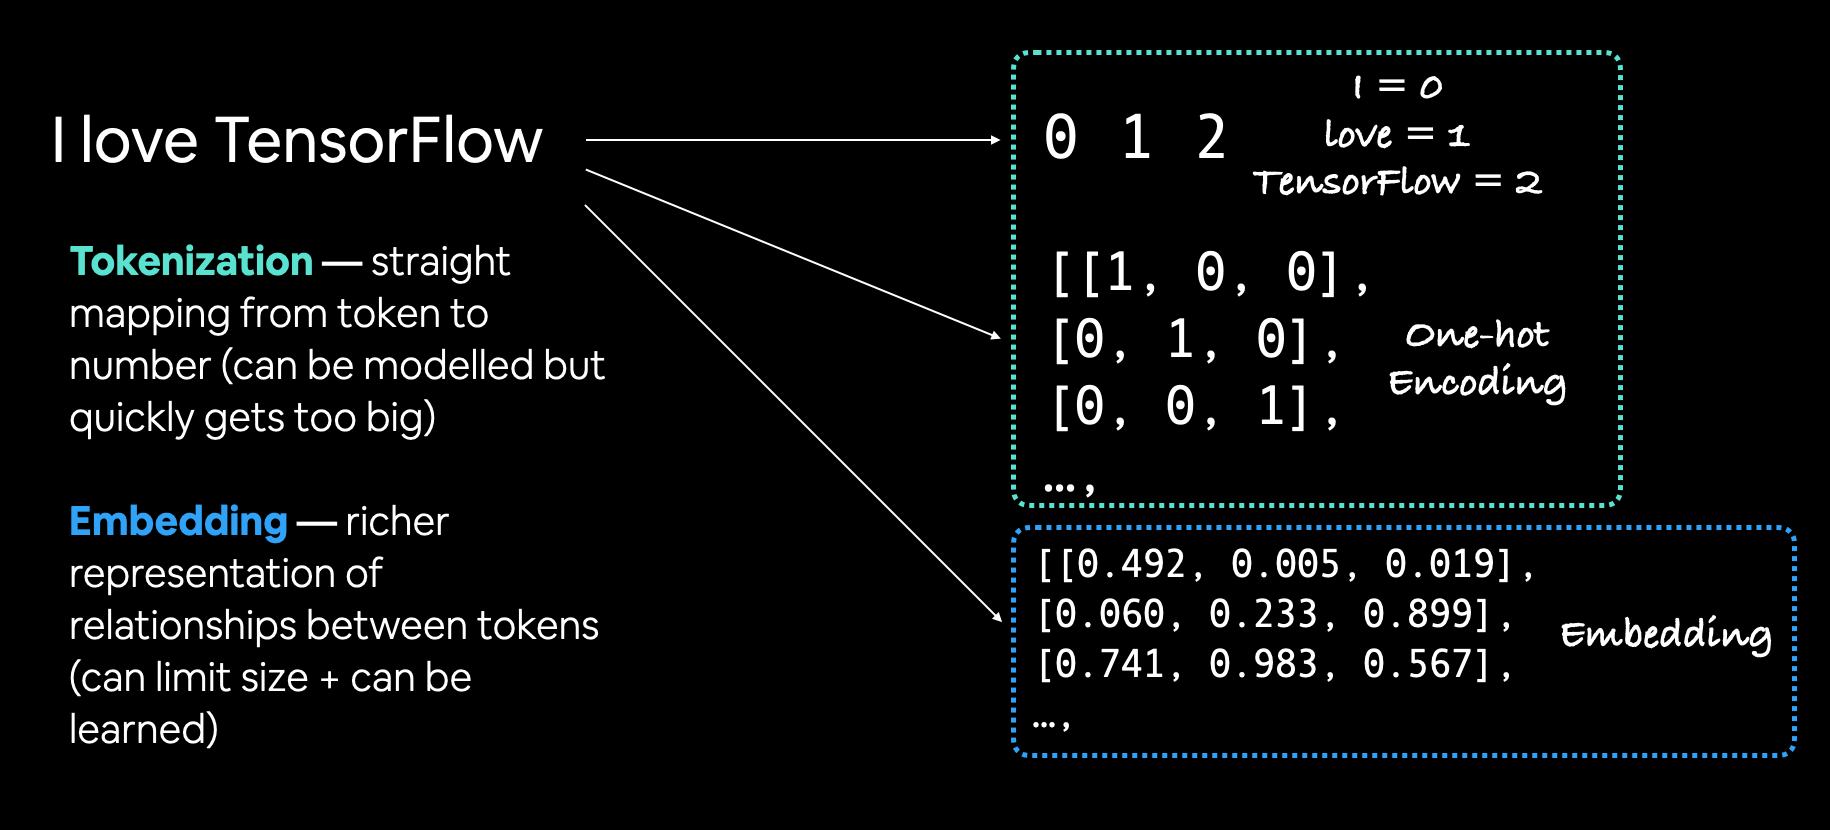

Example of tokenization* (straight mapping from word to number) and embedding (richer representation of relationships between tokens).*

## Text vectorization (tokenization)

To tokenize our words, we'll use the helpful preprocessing layer `tf.keras.layers.experimental.preprocessing.TextVectorization`.

The TextVectorization layer takes the following parameters:

- `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.

- `standardize` - Method for standardizing text. Default is "lower_and_strip_punctuation" which lowers text and removes all punctuation marks.

- `split` - How to split text, default is "whitespace" which splits on spaces.

- `ngrams` - How many words to contain per token split, for example, ngrams=2 splits tokens into continuous sequences of 2.

- `output_mode` - How to output tokens, can be "int" (integer mapping), "binary" (one-hot encoding), "count" or "tf-idf". See documentation for more.

- `output_sequence_length` - Length of tokenized sequence to output. For example, if output_sequence_length=150, all tokenized sequences will be 150 tokens long.

- `pad_to_max_tokens` - Defaults to False, if True, the output feature axis will be padded to max_tokens even if the number of unique tokens in the vocabulary is less than max_tokens. Only valid in certain modes, see docs for more.

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default text vectorization variables
text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length = None)
                                    # pad_to_max_tokens = True)

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (10,000, 20,000, 30,000) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `tput_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [16]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Now let's create another TextVectorization object using our custom parameters.

In [17]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

Training data mapped! Let's try our `text_vectorizer` on a custom sentence (one similar to what you might see in the training data).

In [19]:
# Create sample sentence and tokenize it
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\
      \n\nVectorized Version:')
text_vectorizer([random_sentence])

Original text:
Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/jCDd6SD6Qn http://t.co/9gUCkjghms      

Vectorized Version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 808,  232, 1541, 2206, 2209, 2145, 1090, 1010,  166,  540,  792,
        1910, 1189, 1853, 1076]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f'Number of words in token: {len(words_in_vocab)}')
print(f'Top 5 most common words in vocabulary: {top_5_words}')
print(f'Top 5 least common words in vocabulary: {bottom_5_words}')

Number of words in token: 10000
Top 5 most common words in vocabulary: ['', '[UNK]', 'the', 'a', 'in']
Top 5 least common words in vocabulary: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding using an Embedding Layer

The main parameters we're concerned about here are:

- `input_dim` - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).

- `output_dim` - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.

- `embeddings_initializer` - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.

- `input_length` - Length of sequences being passed to embedding layer.

In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer = 'uniform',
                             input_length = max_length,
                             name = 'embedding_1')

embedding

In [23]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f'Original Sentence:\n {random_sentence}\
n\n\nEmbedding version:')

# Embed the random sentence(turn it into numerical categories)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Sentence:
 @NicolaClements4 IÛªm not sure that covering my head in wounds and scabs is the solution ;)n

Embedding version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03180274, -0.04098036,  0.00431626, ..., -0.00675604,
         -0.0274416 ,  0.02083898],
        [ 0.00344528, -0.01690165,  0.01624978, ...,  0.01988531,
         -0.03802653, -0.00967567],
        [-0.00379503, -0.01535431, -0.03468722, ...,  0.03352157,
          0.0266378 , -0.04441084],
        ...,
        [ 0.03280214,  0.02360464, -0.03162745, ...,  0.00449356,
         -0.03528682, -0.03570703],
        [ 0.00312065,  0.01642967,  0.01923457, ...,  0.04739449,
          0.00115861,  0.01743908],
        [ 0.03015354, -0.04716973, -0.00991746, ..., -0.03956169,
          0.00289447, -0.02566311]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-3.18027362e-02, -4.09803614e-02,  4.31625918e-03,  6.01611286e-03,
        4.37162817e-04,  4.20310162e-02, -4.72059138e-02,  2.31722854e-02,
       -2.94283759e-02,  3.37064266e-03, -2.97677517e-02,  1.51763223e-02,
       -3.27445753e-02,  4.09847237e-02, -4.72497120e-02,  4.87554409e-02,
       -1.90631282e-02,  4.46234234e-02,  2.75293477e-02, -2.30100043e-02,
        1.69659369e-02,  3.60744260e-02, -8.64726305e-03, -1.13893151e-02,
        3.10680903e-02,  4.15744297e-02,  1.61769055e-02,  3.82230319e-02,
        2.65258811e-02, -4.01067734e-02, -4.34070826e-02, -2.98054945e-02,
       -2.51288172e-02, -3.32464203e-02, -3.72586139e-02, -3.47871296e-02,
        8.70710611e-03,  4.74615358e-02,  2.20156051e-02, -3.68650779e-02,
        2.37934254e-02,  9.42235067e-03,  2.82743908e-02, -2.91764494e-02,
        3.10954712e-02, -4.83178161e-02, -4.08053286e-02,  1.25324242e-02,
        6.75697252e-03,  3.34690101e-02,  2.28995420

These values might not mean much to us but they're what our computer sees each word as. When our model looks for patterns in different samples, these values will be updated as necessary.

## Model 0: Getting a baseline

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create Tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our Baseline model achieves an accuracy of: {baseline_score * 100:.2f}%")

Our Baseline model achieves an accuracy of: 79.27%


In [27]:
# Make Predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Creating an evaluation function for our model experiments

 let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

- Accuracy
- Precision
- Recall
- F1-score

In [28]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [29]:
# Get the baseline results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A simple dense model

we're going to be building a number of TensorFlow deep learning models, we'll import our `create_tensorboard_callback()` function from `helper_functions.py` to keep track of the results of each.

In [30]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

Now we've got a TensorBoard callback function ready to go, let's build our first deep model.

In [31]:
# Building a model with Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = "string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation = "sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name = "Model_1_dense")

In [32]:
# Compile the model
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [33]:
# Get a summary of model
model_1.summary()

Model: "Model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [34]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = "simple dense model")])

Saving TensorBoard log files to: model_logs/simple dense model/20230915-150432
Epoch 1/5
215/215 [==============================] - 8s 33ms/step - loss: 0.6086 - accuracy: 0.6948 - val_loss: 0.5353 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.4411 - accuracy: 0.8208 - val_loss: 0.4684 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3463 - accuracy: 0.8609 - val_loss: 0.4580 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2847 - accuracy: 0.8918 - val_loss: 0.4630 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2378 - accuracy: 0.9126 - val_loss: 0.4754 - val_accuracy: 0.7861


In [35]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4754 - accuracy: 0.7861


[0.47535240650177, 0.7860892415046692]

In [36]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.02350797,  0.05655066,  0.00853364, ...,  0.00108965,
         -0.03576288,  0.04305948],
        [-0.02868876, -0.03709289,  0.00099061, ..., -0.00262449,
         -0.03059088,  0.02517001],
        [ 0.0258608 ,  0.03823682, -0.00284055, ...,  0.06887177,
         -0.02025261,  0.03849979],
        ...,
        [ 0.03109211, -0.0048492 , -0.00358499, ...,  0.0289721 ,
         -0.02889166, -0.00086038],
        [ 0.02079794,  0.04821588, -0.06446215, ...,  0.02311711,
         -0.0177781 ,  0.03731837],
        [ 0.07603614,  0.10320947, -0.08718316, ...,  0.06853925,
         -0.03153069,  0.08853691]], dtype=float32)>]

In [37]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [38]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
   --name "First deep model on text data" \
   --description "Trying a dense model with an embedding layer" \
  --one_shot # exits the uploader when upload has finished

2023-09-15 15:05:18.026096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   MQJF-GBXP



New experiment created. View your TensorBoard at: https://tensorboard.dev/experimen

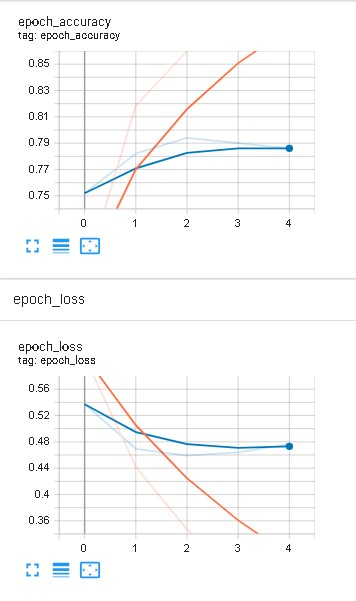

In [39]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 2ms/step


array([[0.41437   ],
       [0.74594355],
       [0.9976259 ],
       [0.1117848 ],
       [0.11300382],
       [0.9352721 ],
       [0.9148066 ],
       [0.9928541 ],
       [0.96931344],
       [0.26344314]], dtype=float32)

Since our final layer uses a sigmoid activation function, we get our predictions back in the form of probabilities.

To convert them to prediction classes, we'll use tf.round(), meaning prediction probabilities below 0.5 will be rounded to 0 and those above 0.5 will be rounded to 1.

In [40]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # Squeeze removes all single Dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Now we've got our model's predictions in the form of classes, we can use our `calculate_results()` function to compare them to the ground truth validation labels.

In [41]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [42]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f'Baseline {key}: {value: .2f}, New {key}: {new_model_results[key]-value:.2f}")')

compare_baseline_to_new_results(baseline_results = baseline_results,
                                new_model_results = model_1_results)

Baseline accuracy:  79.27, New accuracy: -0.66")
Baseline precision:  0.81, New precision: -0.02")
Baseline recall:  0.79, New recall: -0.01")
Baseline f1:  0.79, New f1: -0.00")


## Visualizing learned embeddings

Our first model (model_1) contained an embedding layer (embedding) which learned a way of representing words as feature vectors by passing over the training data.

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [45]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0:
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:



1.   Go to http://projector.tensorflow.org/
2.   Click on "Load data"
3.   Upload the two files you downloaded (embedding_vectors.tsv and embedding_metadata.tsv)
4.   Explore
5. Optional: You can share the data you've created by clicking "Publish"

**Do you have to visualize embeddings every time?**

No. Although helpful for gaining an intuition of what natural language embeddings are, it's not completely necessary. Especially as the dimensions of your vocabulary and embeddings grow, trying to comprehend them would become an increasingly difficult task.







# Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a Recurrent Neural Network (RNN).

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input `(X)` and compute an output `(y)` based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog.

See what happened there?

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:

1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:

- **One to one**: one input, one output, such as image classification.

- **One to many**: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).

- **Many to one**: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).

- **Many to many**: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:

- Long short-term memory cells (LSTMs).
- Gated recurrent units (GRUs).
- Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

## Model 2: LSTM

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use `tensorflow.keras.layers.LSTM()`.

Our model is going to take on a very similar structure to model_1:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)



In [46]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_2')

# Create LSTM Model
inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'Model_2_LSTM')

(None, 15, 128)
(None, 64)


Now we've got our LSTM model built, let's compile it using `"binary_crossentropy"` loss and the Adam optimizer.

In [47]:
# Compile the model
model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [48]:
model_2.summary()

Model: "Model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [49]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, 'LSTM')])

Saving TensorBoard log files to: model_logs/LSTM/20230915-151059
Epoch 1/5
215/215 [==============================] - 14s 52ms/step - loss: 0.5093 - accuracy: 0.7454 - val_loss: 0.4593 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 10s 45ms/step - loss: 0.3168 - accuracy: 0.8720 - val_loss: 0.5151 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 9s 41ms/step - loss: 0.2195 - accuracy: 0.9158 - val_loss: 0.5861 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 10s 46ms/step - loss: 0.1569 - accuracy: 0.9453 - val_loss: 0.6190 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 10s 47ms/step - loss: 0.1095 - accuracy: 0.9609 - val_loss: 0.8161 - val_accuracy: 0.7651


In [50]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


((762, 1),
 array([[0.00942013],
        [0.7344352 ],
        [0.9990087 ],
        [0.06298816],
        [0.0034677 ],
        [0.9993022 ],
        [0.7259617 ],
        [0.99956274],
        [0.999412  ],
        [0.27538925]], dtype=float32))

In [51]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

 now let's use our `caculate_results()` function to evaluate our LSTM model and our `compare_baseline_to_new_results()` function to compare it to our baseline model.

In [52]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 76.50918635170603,
 'precision': 0.7662169502191715,
 'recall': 0.7650918635170604,
 'f1': 0.7631560582067719}

In [53]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy:  79.27, New accuracy: -2.76")
Baseline precision:  0.81, New precision: -0.04")
Baseline recall:  0.79, New recall: -0.03")
Baseline f1:  0.79, New f1: -0.02")


##Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

To use the GRU cell in TensorFlow, we can call the `tensorflow.keras.layers.GRU()` class.

The architecture of the GRU-powered model will follow the same structure we've been using:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [54]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

model_3_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_3')

# Build a RNN Model using GRU cell
inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'Model_3_GRU')

In [56]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
# Get model summary
model_3.summary()

Model: "Model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

Notice the difference in number of trainable parameters between `model_2` (LSTM) and `model_3` (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

We'll fit our model just as we've been doing previously. We'll also track our models results using our `create_tensorboard_callback()` function.

In [59]:
# Fit the model
model_3.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR, 'GRU')])

Saving TensorBoard log files to: model_logs/GRU/20230915-152614
Epoch 1/5
215/215 [==============================] - 13s 47ms/step - loss: 0.5280 - accuracy: 0.7246 - val_loss: 0.4537 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 9s 43ms/step - loss: 0.3183 - accuracy: 0.8673 - val_loss: 0.4894 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 9s 43ms/step - loss: 0.2183 - accuracy: 0.9183 - val_loss: 0.5564 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 10s 44ms/step - loss: 0.1566 - accuracy: 0.9451 - val_loss: 0.6141 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 10s 45ms/step - loss: 0.1185 - accuracy: 0.9594 - val_loss: 0.6173 - val_accuracy: 0.7730


In [60]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


((762, 1),
 array([[0.385216  ],
        [0.91398704],
        [0.9976716 ],
        [0.15823685],
        [0.01359542],
        [0.992296  ],
        [0.70518684],
        [0.9970454 ],
        [0.99662906],
        [0.6598379 ]], dtype=float32))

In [61]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Now we've got predicted classes, let's evaluate them against the ground truth labels.

In [62]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7726091269398356,
 'recall': 0.7729658792650919,
 'f1': 0.772485380005067}

In [63]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy:  79.27, New accuracy: -1.97")
Baseline precision:  0.81, New precision: -0.04")
Baseline recall:  0.79, New recall: -0.02")
Baseline f1:  0.79, New f1: -0.01")


# Model 4: Bidirectonal RNN model

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Once again, TensorFlow helps us out by providing the `tensorflow.keras.layers.Bidirectional` class. We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

In [65]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = 'uniform',
                                     input_length = max_length,
                                     name = 'embedding_4')

# Build a bidirectional RNN in Tensorflow
inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = 'model_4_Bidirectional')

In [66]:
# Compile the model
model_4.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [68]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

Notice the increased number of trainable parameters in model_4 (bidirectional LSTM) compared to model_2 (regular LSTM). This is due to the bidirectionality we added to our RNN.

In [67]:
# Fit the model
model_4.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks = [create_tensorboard_callback(SAVE_DIR, 'Bidirectional RNN')])

Saving TensorBoard log files to: model_logs/Bidirectional RNN/20230915-153537
Epoch 1/5
215/215 [==============================] - 19s 62ms/step - loss: 0.5094 - accuracy: 0.7468 - val_loss: 0.4588 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 13s 58ms/step - loss: 0.3129 - accuracy: 0.8717 - val_loss: 0.5119 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 13s 59ms/step - loss: 0.2125 - accuracy: 0.9193 - val_loss: 0.5610 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 13s 59ms/step - loss: 0.1496 - accuracy: 0.9461 - val_loss: 0.6363 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 12s 58ms/step - loss: 0.1063 - accuracy: 0.9637 - val_loss: 0.6493 - val_accuracy: 0.7795


In [69]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.04667514],
       [0.8306234 ],
       [0.9993655 ],
       [0.12858826],
       [0.00790766],
       [0.99522805],
       [0.80995244],
       [0.99972624],
       [0.99953747],
       [0.34769598]], dtype=float32)

In [70]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.95275590551181,
 'precision': 0.7795261140776376,
 'recall': 0.7795275590551181,
 'f1': 0.7786058734339147}

In [72]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy:  79.27, New accuracy: -1.31")
Baseline precision:  0.81, New precision: -0.03")
Baseline recall:  0.79, New recall: -0.01")
Baseline f1:  0.79, New f1: -0.01")


# Convolutional Neural Networks for Text

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following:

Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a `tensorflow.keras.layers.Conv1D()` layer followed by a `tensorflow.keras.layers.GlobablMaxPool1D()` layer.

# Model 5: Conv1D
Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a temporal convolution) in action.

We'll first create an embedding of a sample of text and experiment passing it through a Conv1D() layer and GlobalMaxPool1D() layer.

In [73]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(['this is a test sentence'])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu') # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

The embedding has an output shape dimension of the parameters we set it to (input_length=15 and output_dim=128).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

In [74]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01056502, -0.01417253,  0.01048073, ..., -0.04504951,
          -0.01917922,  0.05118822],
         [ 0.06889998,  0.05557683, -0.06612504, ...,  0.03625897,
          -0.0672398 , -0.00558167],
         [-0.00470977, -0.02043354, -0.01700605, ...,  0.03741114,
          -0.03605833, -0.01140493],
         ...,
         [ 0.02350797,  0.05655066,  0.00853364, ...,  0.00108965,
          -0.03576288,  0.04305948],
         [ 0.02350797,  0.05655066,  0.00853364, ...,  0.00108965,
          -0.03576288,  0.04305948],
         [ 0.02350797,  0.05655066,  0.00853364, ...,  0.00108965,
          -0.03576288,  0.04305948]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.02051435, 0.02262366, 0.        , 0.02273306,
          0.06000216, 0.0735566 , 0.01241913, 0.03169982, 0.03984419,
          0.0170536 , 0.02040661, 0.07275825, 0.00528637, 0.        ,
          0.07982022, 0.

In [75]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape = (1, ), dtype = 'string')
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters = 32, kernel_size=5, activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'Model_5_Conv1D')

In [76]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
# Get a summary of our 1D convolution model
model_5.summary()

Model: "Model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)              

Notice how the number of trainable parameters for the 1-dimensional convolutional layer is similar to that of the LSTM layer in `model_2`.

In [78]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230915-160817
Epoch 1/5
215/215 [==============================] - 7s 30ms/step - loss: 0.5450 - accuracy: 0.7205 - val_loss: 0.4697 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3376 - accuracy: 0.8548 - val_loss: 0.5085 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2325 - accuracy: 0.9104 - val_loss: 0.5821 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 7s 31ms/step - loss: 0.1689 - accuracy: 0.9333 - val_loss: 0.6801 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1261 - accuracy: 0.9494 - val_loss: 0.7744 - val_accuracy: 0.7638


In [79]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.54871273],
       [0.8042548 ],
       [0.9999911 ],
       [0.01959302],
       [0.01512176],
       [0.9811254 ],
       [0.85481364],
       [0.9993785 ],
       [0.9999962 ],
       [0.16356178]], dtype=float32)

In [80]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.37795275590551,
 'precision': 0.7636075752388659,
 'recall': 0.7637795275590551,
 'f1': 0.762792007250623}

In [82]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy:  79.27, New accuracy: -2.89")
Baseline precision:  0.81, New precision: -0.05")
Baseline recall:  0.79, New recall: -0.03")
Baseline f1:  0.79, New f1: -0.02")


# Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

# Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

We can load in a TensorFlow Hub module using the `hub.load()` method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

In [83]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01602833  0.01068852  0.02425469 -0.01405768  0.01434427  0.08292625
  0.01963371  0.06160141 -0.00352697 -0.01216412  0.00978647 -0.01248495
  0.01232345  0.09748449  0.06141113 -0.03728353  0.01860886 -0.04669856
  0.00413911 -0.06363907 -0.024699    0.0271369   0.02284443 -0.00210027
 -0.00630594 -0.03964962  0.02220404  0.00115079 -0.03132173  0.00119527
 -0.04012547  0.04561891 -0.015306   -0.00175918  0.02173132 -0.08450423
  0.03340025  0.04604552 -0.02480248 -0.08681665  0.00702694 -0.0077048
 -0.01434541  0.07814164 -0.10676058 -0.05152994 -0.00858157 -0.03232231
 -0.03871097  0.02581466], shape=(50,), dtype=float32)


In [84]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

In [87]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [], # shape of inputs coming to our model
                                        dtype = tf.string, # data type of inputs coming to the USE layer
                                        trainable = False, # keep the pretrained weights (we'll create a feature extractor)
                                        name = 'USE')

In [88]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
], name = 'Model_6_USE')

In [89]:
# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [90]:
model_6.summary()

Model: "Model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources Wikipedia, web news, web question-answer forums, etc,

In [91]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230915-161527
Epoch 1/5
215/215 [==============================] - 8s 22ms/step - loss: 0.5029 - accuracy: 0.7859 - val_loss: 0.4476 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4146 - accuracy: 0.8137 - val_loss: 0.4363 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3999 - accuracy: 0.8221 - val_loss: 0.4322 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3926 - accuracy: 0.8251 - val_loss: 0.4271 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3862 - accuracy: 0.8297 - val_loss: 0.4283 - val_accuracy: 0.8150


In [92]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.15735053],
       [0.73363113],
       [0.9863601 ],
       [0.20063089],
       [0.7446711 ],
       [0.6793257 ],
       [0.982709  ],
       [0.97675484],
       [0.9238321 ],
       [0.08185011]], dtype=float32)

In [93]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8175707797736699,
 'recall': 0.8149606299212598,
 'f1': 0.8133343159175271}

In [95]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy:  79.27, New accuracy: 2.23")
Baseline precision:  0.81, New precision: 0.01")
Baseline recall:  0.79, New recall: 0.02")
Baseline f1:  0.79, New f1: 0.03")


# Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [98]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
import numpy as np

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [99]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [100]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [101]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "Model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Notice the layout of model_7 is the same as model_6. Now let's train the newly created model on our 10% training data subset.

In [102]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230915-161821
Epoch 1/5
22/22 [==============================] - 4s 57ms/step - loss: 0.6674 - accuracy: 0.7114 - val_loss: 0.6460 - val_accuracy: 0.7152
Epoch 2/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5902 - accuracy: 0.8163 - val_loss: 0.5856 - val_accuracy: 0.7546
Epoch 3/5
22/22 [==============================] - 1s 32ms/step - loss: 0.5102 - accuracy: 0.8280 - val_loss: 0.5318 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4466 - accuracy: 0.8338 - val_loss: 0.5020 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4052 - accuracy: 0.8426 - val_loss: 0.4870 - val_accuracy: 0.7795


Due to the smaller amount of training data, training happens even quicker than before.

Let's evaluate our model's performance after learning on 10% of the training data.

In [103]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 19ms/step


array([[0.24031635],
       [0.8072839 ],
       [0.89253104],
       [0.27864173],
       [0.5438691 ],
       [0.82683694],
       [0.8321474 ],
       [0.8380243 ],
       [0.8262358 ],
       [0.12550816]], dtype=float32)

In [104]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [105]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7849754984084437,
 'recall': 0.7795275590551181,
 'f1': 0.7761172470890804}

In [106]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy:  79.27, New accuracy: -1.31")
Baseline precision:  0.81, New precision: -0.03")
Baseline recall:  0.79, New recall: -0.01")
Baseline f1:  0.79, New f1: -0.01")


# Comparing the performance of each of our models

In [107]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,76.509186,0.766217,0.765092,0.763156
gru,77.296588,0.772609,0.772966,0.772485
bidirectional,77.952756,0.779526,0.779528,0.778606
conv1d,76.377953,0.763608,0.763780,0.762792
tf_hub_sentence_encoder,81.496063,0.817571,0.814961,0.813334
tf_hub_10_percent_data,77.952756,0.784975,0.779528,0.776117


In [108]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

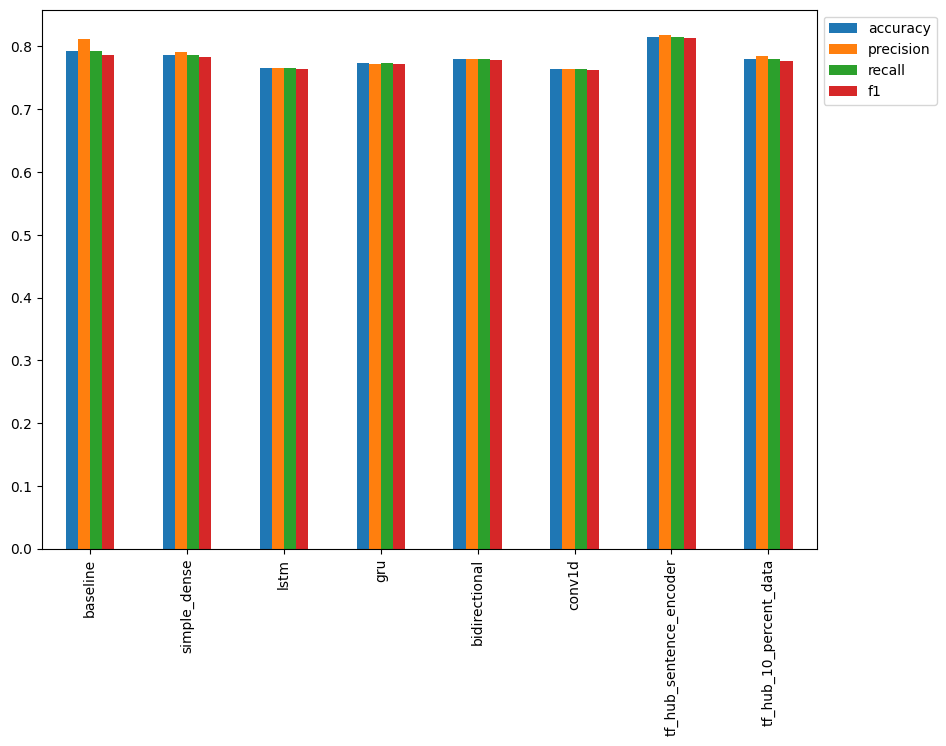

In [109]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Looks like our pretrained USE TensorFlow Hub models have the best performance, even the one with only 10% of the training data seems to outperform the other models. This goes to show the power of transfer learning.

How about we drill down and get the F1-score's of each model?

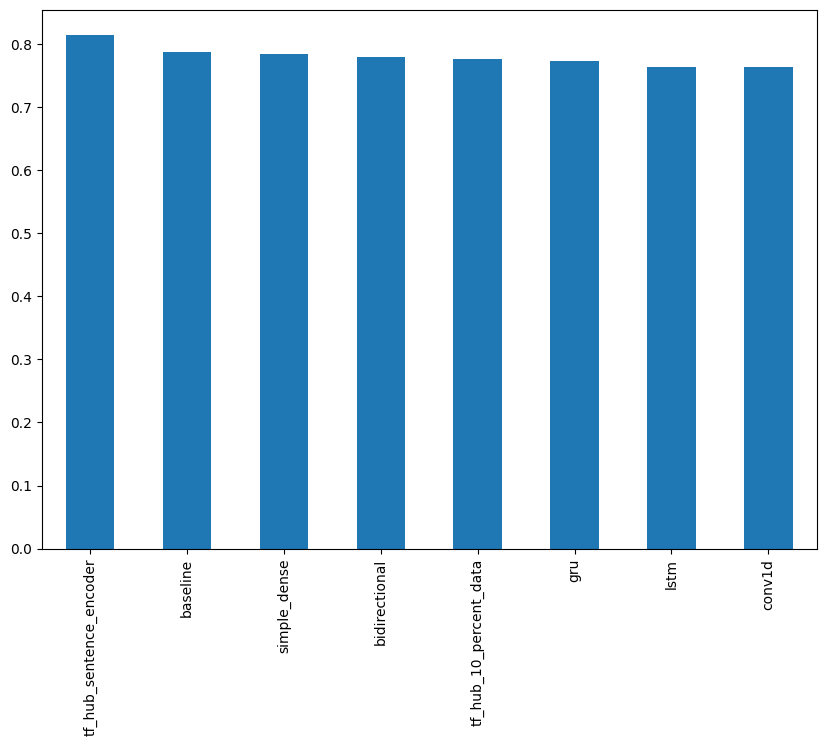

In [110]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Drilling down into a single metric we see our USE TensorFlow Hub models performing better than all of the other models. Interestingly, the baseline's F1-score isn't too far off the rest of the deeper models.

We can also visualize all of our model's training logs using TensorBoard.dev.

In [111]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
   --name "NLP modelling experiments" \
   --description "A series of different NLP modellings experiments with various models" \
   --one_shot # exits the uploader when upload has finished

2023-09-15 16:20:51.899453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/2ZEeTD9zRjqMvmuKR0MjSg/

[2023-09-15T16:20:54] Started scanning logdir.
[2023-09-15T16:21:01] Total uploaded: 210 scalars, 0 tensors, 7 binary objects (2.9 MB)
[2023-09-15T16:21:01] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/2ZEeTD9zRjqMvmuKR0MjSg/


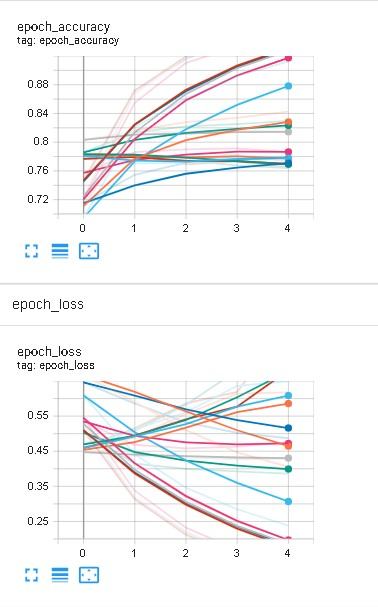

# Saving and loading a trained model

- The `HDF5` format.
- The `SavedModel` format (default).

In [112]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [113]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [114]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [115]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [116]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4283 - accuracy: 0.8150


[0.4282998740673065, 0.8149606585502625]

As you can see saving and loading our model with either format results in the same performance.

# 🤔 Question: Should you used the SavedModel format or HDF5 format?

For most use cases, the SavedModel format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, HDF5 might be better.

# Making predictions on the test dataset
 we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [117]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 52ms/step
Pred: 0, Prob: 0.13905684649944305
Text:
@wizkhalifa smoke ??so much you don't gotta do shit but light?? one of his locks on fire  ...that's like a whole tre five right there.

----

1/1 [==============================] - 0s 45ms/step
Pred: 0, Prob: 0.2844371497631073
Text:
This week we received the sad news of our friends daughters cancer prognosis. This is the second upheaval in this... http://t.co/tpOptWMWFR

----

1/1 [==============================] - 0s 46ms/step
Pred: 0, Prob: 0.29163122177124023
Text:
the wounds of honor
 are self-inflicted

----

1/1 [==============================] - 0s 51ms/step
Pred: 1, Prob: 0.934452474117279
Text:
Middle East ÛÏHeat DomeÛ Causes Crippling Heat Wave in Israel http://t.co/41Lcb9aepR

----

1/1 [==============================] - 0s 59ms/step
Pred: 1, Prob: 0.9636585712432861
Text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' dis

# Predicting on Tweets from the wild

In [118]:
# Turn Tweet into string
tweet = 'How the West was burned: Thousands of wildfires ablaze in California alone'

In [119]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [122]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=tweet)

1/1 [==============================] - 0s 43ms/step
Pred: 1.0 (real disaster) Prob: 0.991247832775116
Text:
How the West was burned: Thousands of wildfires ablaze in California alone


In [121]:
beirut_tweet = 'Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent.'

In [123]:
predict_on_sentence(model=model_6, # use the USE model
                    sentence=beirut_tweet)

1/1 [==============================] - 0s 44ms/step
Pred: 1.0 (real disaster) Prob: 0.9098724126815796
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent.


In [124]:
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [126]:
predict_on_sentence(model=model_6, # use the USE model
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 44ms/step
Pred: 1.0 (real disaster) Prob: 0.9705256819725037
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


# The speed/score tradeoff

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model.

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, let's write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.

In [127]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [128]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 11ms/step


(0.3886797929999375, 0.0005100784685038549)

In [129]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.041965705999245984, 5.5073104985887116e-05)

Let's compare time per prediction versus our model's F1-scores.

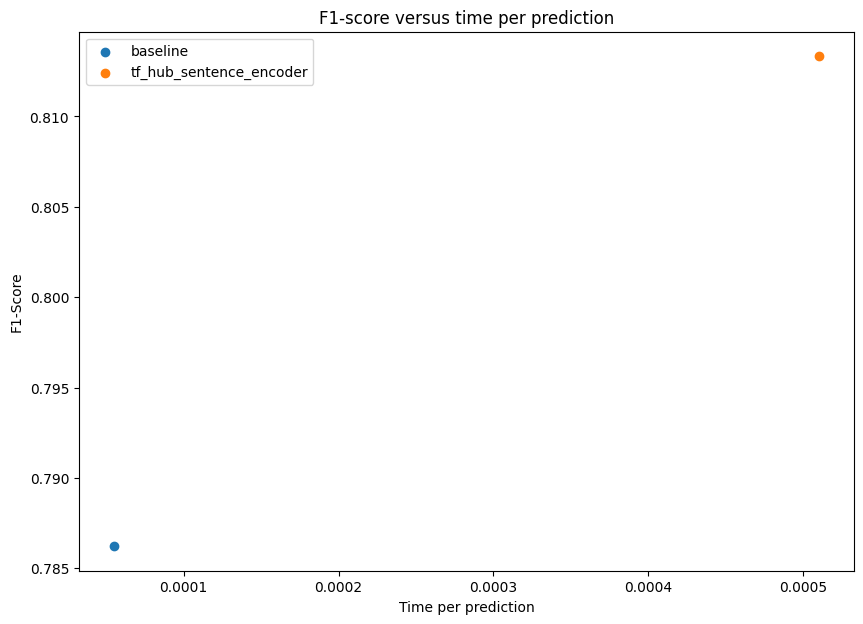

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

Ideal position for speed and performance tradeoff model (fast predictions with great results).

Of course, the ideal position for each of these dots is to be in the top left of the plot (low time per prediction, high F1-score).

In our case, there's a clear tradeoff for time per prediction and performance. Our best performing model takes an order of magnitude longer per prediction but only results in a few F1-score point increase.

This kind of tradeoff is something you'll need to keep in mind when incorporating machine learning models into your own applications.